In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from numpy import sqrt
from math import exp
from numpy import log

import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

## Data Analysis

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [0]:
date_all = df['date'].values
value_all = df['value'].values

In [4]:
date_all[0:10]

array(['1991-07-01T00:00:00.000000000', '1991-08-01T00:00:00.000000000',
       '1991-09-01T00:00:00.000000000', '1991-10-01T00:00:00.000000000',
       '1991-11-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1992-03-01T00:00:00.000000000', '1992-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


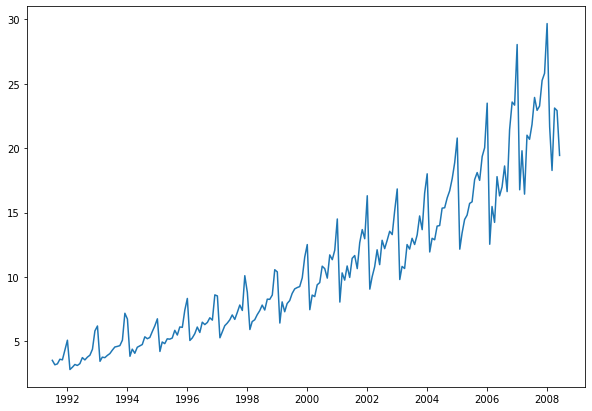

In [5]:
plt.rcParams.update({'figure.figsize': (10, 7)})
plt.plot(date_all, value_all)
plt.show()

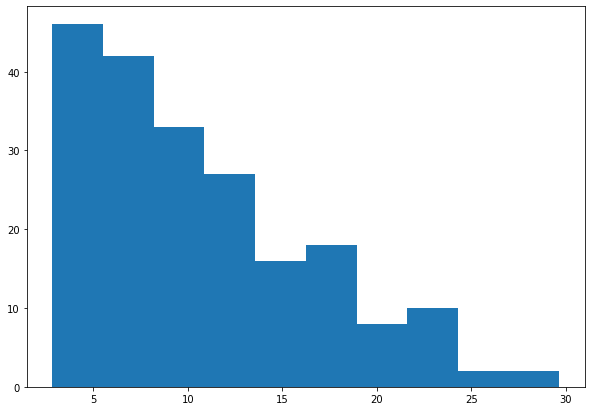

In [7]:
plt.hist(value_all)
plt.show()

We can see that the the time series has a quadratic growth. Also, the series is non-stationary as mean varies along each point and histogram plot is non-uniform.

## Moving Average

In [9]:
from numpy import mean
from sklearn.metrics import mean_squared_error
X = value_all
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(test)):
  length = len(history)
  yhat = mean([history[i] for i in range(length-window,length)])
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=3.319901, expected=3.611003
predicted=3.348038, expected=3.565869
predicted=3.476364, expected=4.306371
predicted=3.827748, expected=5.088335
predicted=4.320192, expected=2.814520
predicted=4.069742, expected=2.985811
predicted=3.629555, expected=3.204780
predicted=3.001704, expected=3.127578
predicted=3.106056, expected=3.270523
predicted=3.200960, expected=3.737851
predicted=3.378651, expected=3.558776
predicted=3.522383, expected=3.777202
predicted=3.691276, expected=3.924490
predicted=3.753489, expected=4.386531
predicted=4.029408, expected=5.810549
predicted=4.707190, expected=6.192068
predicted=5.463049, expected=3.450857
predicted=5.151158, expected=3.772307
predicted=4.471744, expected=3.734303
predicted=3.652489, expected=3.905399
predicted=3.804003, expected=4.049687
predicted=3.896463, expected=4.315566
predicted=4.090217, expected=4.562185
predicted=4.309146, expected=4.608662
predicted=4.495471, expected=4.667851
predicted=4.612899, expected=5.093841
predicted=4.

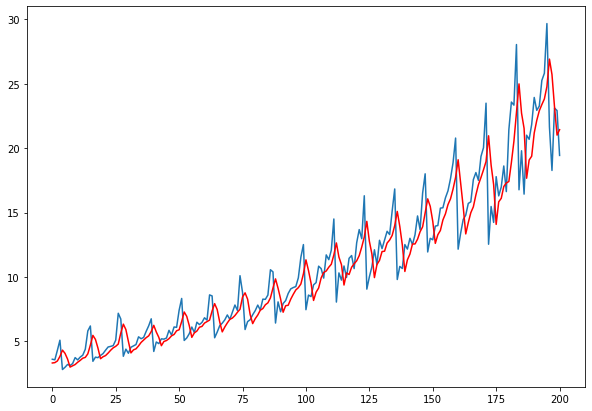

In [10]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## ARIMA (Autoregressive Integrated Moving Average)

For this, let's convert the series to stationary at first. There are different ways to do this. Let's try different approaches and choose the most uniform one.

### 1. Differencing

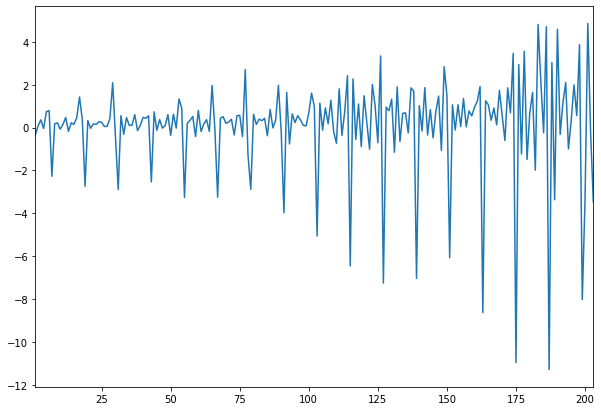

In [11]:
df_copy1 = df['value'].copy()
df_copy1 = df['value'] - df['value'].shift(1)
df_copy1.dropna().plot()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


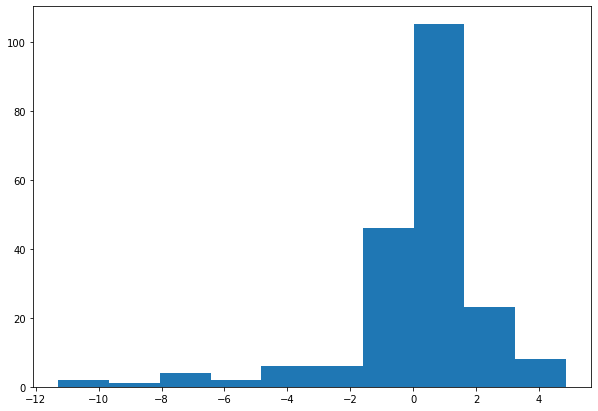

In [12]:
plt.hist(df_copy1)
plt.show()

### 2. Seasonal differencing

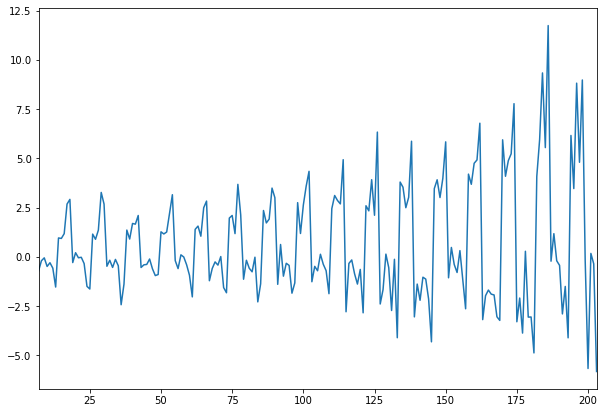

In [13]:
n = 7
df_copy2 = df['value'] - df['value'].shift(n)
df_copy2.dropna().plot()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


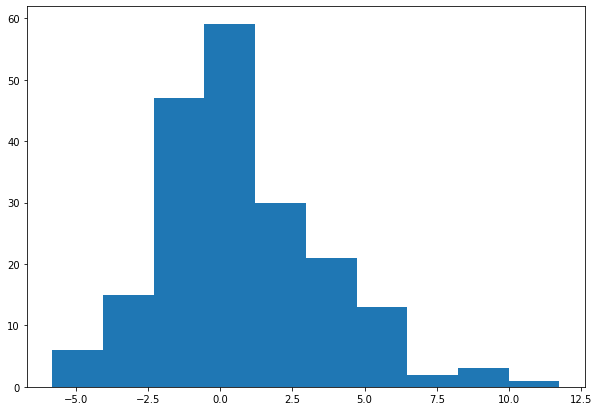

In [14]:
plt.hist(df_copy2)
plt.show()

### 3. Log Transform

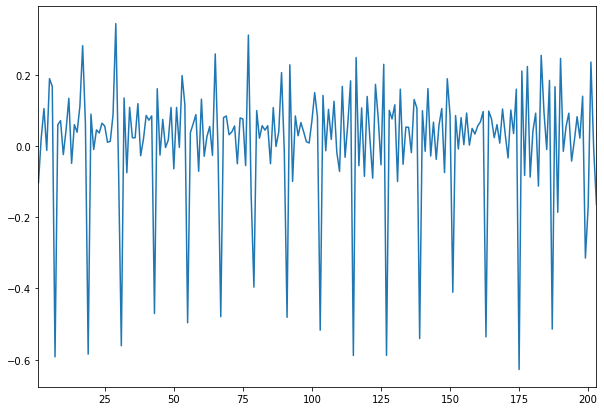

In [15]:
df_copy3 = df.copy()
df_copy3['value'] = np.log(df_copy3['value'])

## variance plot
df_copy3['value_diff'] = df_copy3['value']-df_copy3['value'].shift(1)
df_copy3['value_diff'].dropna().plot()

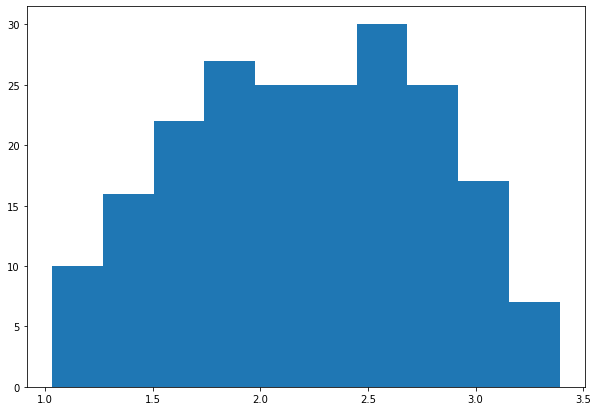

In [16]:
plt.hist(df_copy3['value'])
plt.show()

### 4. Square root

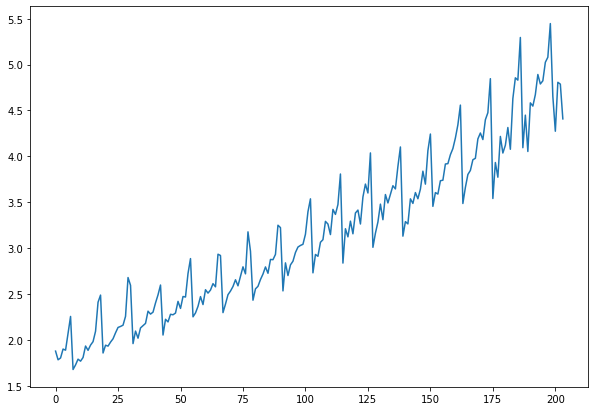

In [17]:
df_copy4 = df.copy()
transform = sqrt(df_copy4['value'])
plt.plot(transform)

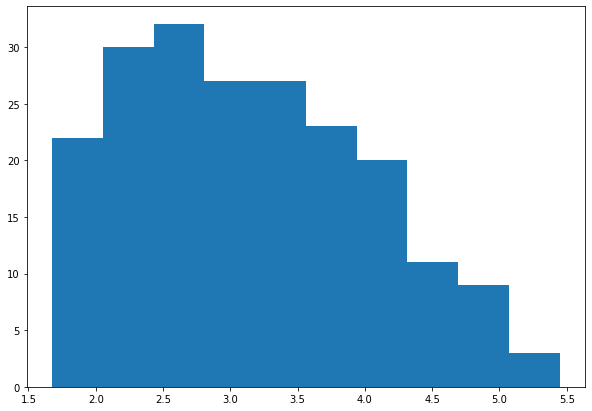

In [18]:
plt.hist(transform)
plt.show()

Among all the methods, the histogram plot provided by log transform seems to be more uniform than the other approaches. Let's use this series to forecast the values.

In [0]:
values = df_copy3['value'][80:150]

### Autocorrelation plot

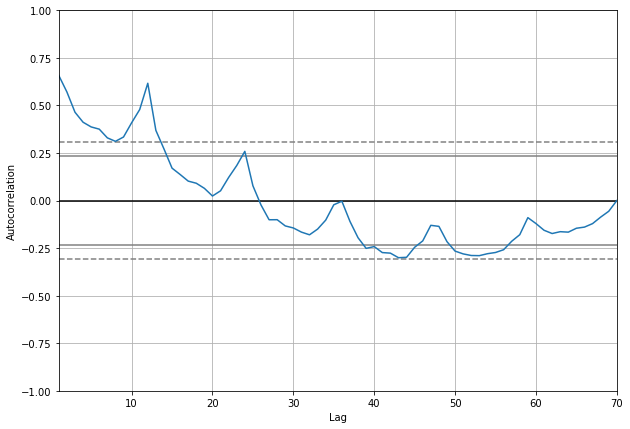

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(values)
plt.show()

### Partial Autocorrelation plot

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


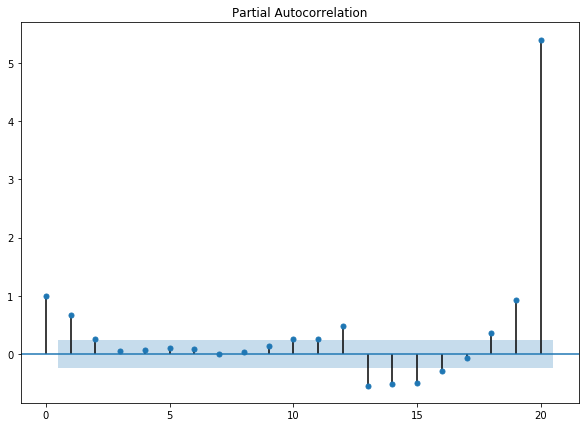

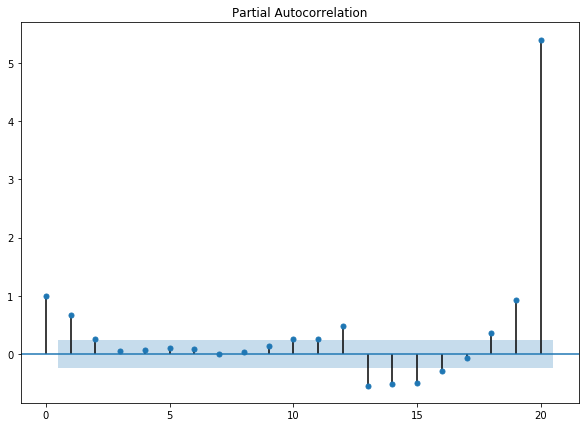

In [21]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(values, lags=20)

Thus, from autocorrelation and partial autocorrelation plot, p = 7 and q = 3. 

In [0]:
# order = [p, d, q]
model = ARIMA(values, order=[7, 1, 3])
model_arima = model.fit()

In [23]:
predictions = model_arima.forecast(20)
predictions

(array([2.75990868, 2.64209196, 2.69237205, 2.71041844, 2.63259536,
        2.73358977, 2.75059915, 2.68728128, 2.77745524, 2.76322234,
        2.7215335 , 2.79865597, 2.77926176, 2.75897703, 2.82431098,
        2.80283882, 2.79512364, 2.84870611, 2.82666934, 2.82888091]),
 array([0.1268068 , 0.1326915 , 0.13452614, 0.13555941, 0.13560296,
        0.13821605, 0.13839962, 0.13944542, 0.14011298, 0.14052203,
        0.14079355, 0.14143361, 0.14159496, 0.14161466, 0.14197862,
        0.14214591, 0.14215611, 0.14234839, 0.14250317, 0.14250317]),
 array([[2.51137192, 3.00844544],
        [2.3820214 , 2.90216252],
        [2.42870566, 2.95603845],
        [2.44472689, 2.97611   ],
        [2.36681844, 2.89837228],
        [2.46269129, 3.00448826],
        [2.47934087, 3.02185743],
        [2.41397328, 2.96058928],
        [2.50283885, 3.05207163],
        [2.48780423, 3.03864045],
        [2.44558321, 2.99748379],
        [2.5214512 , 3.07586075],
        [2.50174073, 3.05678278],
        [2

Let's compare the predicted future values given by the first array with the expected values. (Here, first array = predicted_values, second array = errors, third array = (standard deviation - error, standard deviation + error)

In [25]:
## expected values
[df_copy3['value'][i] for i in range(151, 172)]

[2.479729091837481,
 2.564787813644806,
 2.55588106216984,
 2.6350096351702845,
 2.6383050610178906,
 2.7304049558769075,
 2.732467259633488,
 2.7814248806530926,
 2.814555301472967,
 2.8699835458453613,
 2.937537587675476,
 3.033929530462248,
 2.4977037498284544,
 2.595433198488991,
 2.671333587406578,
 2.6942961800494283,
 2.7539949240152466,
 2.7618784464515937,
 2.8653217772907835,
 2.8959596719391403,
 2.8620104628010874]

Let's plot autocorrelation plot, partial autocorrelation plot and residual plot to evaluate our ARIMA model.

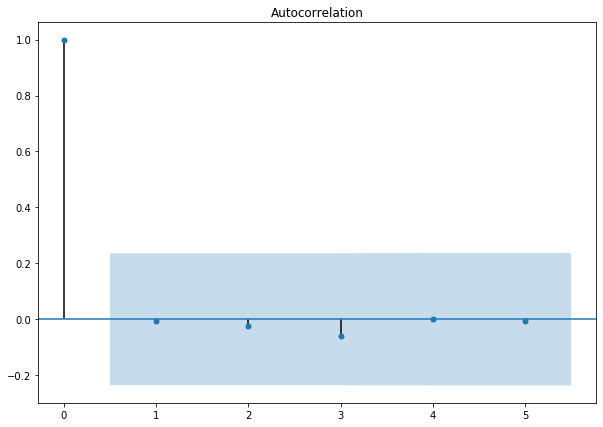

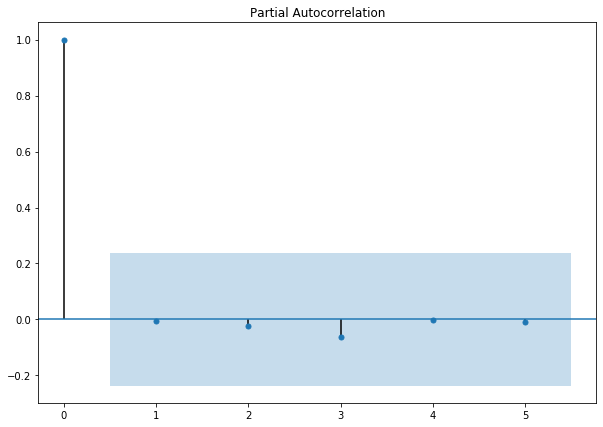

In [26]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(model_arima.resid,lags=5)
sm.graphics.tsa.plot_pacf(model_arima.resid,lags=5)
plt.show()

Here, most of the critical values are nearly equal to zero.

In [0]:
import pandas as pd
residuals = pd.DataFrame(model_arima.resid)

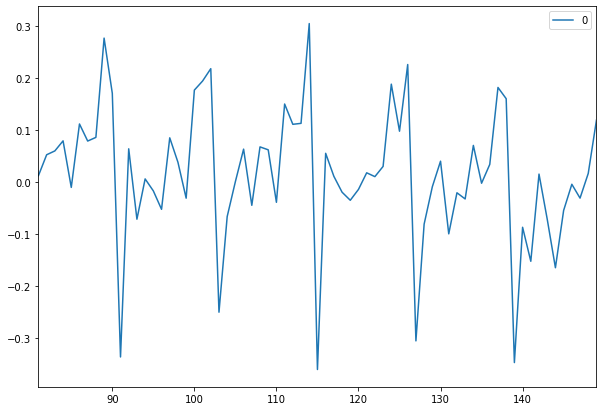

In [28]:
residuals.plot()

The residual plot is approximately stationary.

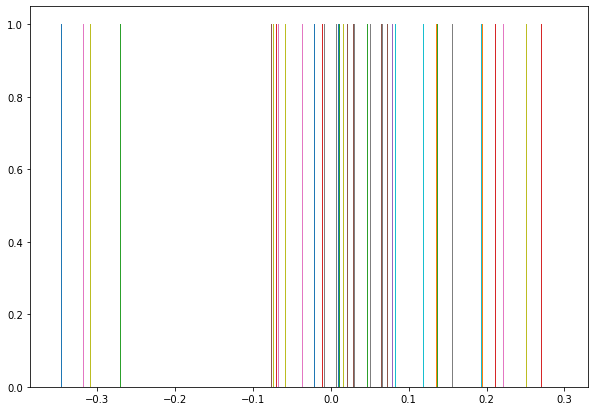

In [29]:
plt.hist(residuals)
plt.show()

In [30]:
residuals.describe()

,0
count,69.000000
mean,0.014966
std,0.133707
min,-0.360600
25%,-0.035222
50%,0.015110
75%,0.084831
max,0.304505


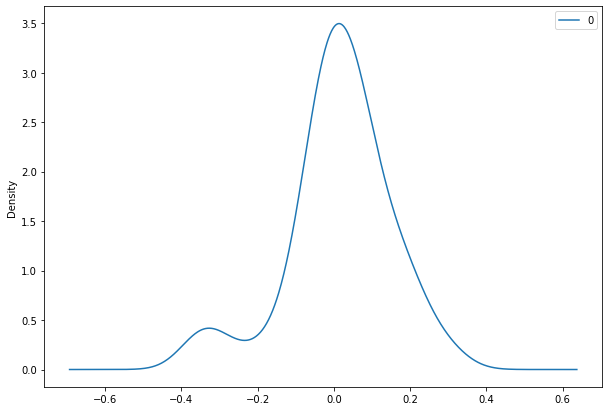

In [31]:
residuals.plot(kind='kde')

As most of the critical values are nearly equal to zero, the residual plot is approximately stationary and the mean is nearly equal to zero; our ARIMA model can be useful for forecasting purposes.